# Proyecto de Fraud Detection
## Juan Sebastian Angel Perez
### Universidad Externado de Colombia
### MINE 9 - Big Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = "../data/fraud_detection_transactions.csv"

df = pd.read_csv(path)

print("Shape:", df.shape)
df.head()


Shape: (50000, 21)


,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


# Tipos de datos + nulos + duplicados

In [28]:
# Información general de columnas y tipos
df.info()

print("\n--- NULOS POR COLUMNA ---")
nulls = df.isna().sum().sort_values(ascending=False)
nulls[nulls > 0]

print("\n--- PORCENTAJE DE NULOS ---")
null_pct = (df.isna().mean() * 100).sort_values(ascending=False)
null_pct[null_pct > 0].round(2)

print("\n--- DUPLICADOS ---")
print("Filas duplicadas totales:", df.duplicated().sum())
print("Transaction_ID duplicados:", df["Transaction_ID"].duplicated().sum())



<class 'pandas.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Transaction_ID                50000 non-null  str           
 1   User_ID                       50000 non-null  str           
 2   Transaction_Amount            50000 non-null  float64       
 3   Transaction_Type              50000 non-null  str           
 4   Timestamp                     50000 non-null  datetime64[us]
 5   Account_Balance               50000 non-null  float64       
 6   Device_Type                   50000 non-null  str           
 7   Location                      50000 non-null  str           
 8   Merchant_Category             50000 non-null  str           
 9   IP_Address_Flag               50000 non-null  int64         
 10  Previous_Fraudulent_Activity  50000 non-null  int64         
 11  Daily_Transaction_Count       50000 non

# Conversión de Timestamp + variables temporales básicas

In [7]:
# Convertir Timestamp a datetime
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

# Verificar conversiones fallidas
print("Timestamps inválidos:", df["Timestamp"].isna().sum())

# Extraer features temporales
df["hour"] = df["Timestamp"].dt.hour
df["day_of_week"] = df["Timestamp"].dt.dayofweek  # 0=Lunes, 6=Domingo
df["month"] = df["Timestamp"].dt.month

# Vista rápida
df[["Timestamp", "hour", "day_of_week", "month", "Is_Weekend"]].head()


Timestamps inválidos: 0


,Timestamp,hour,day_of_week,month,Is_Weekend
0,2023-08-14 19:30:00,19,0,8,0
1,2023-06-07 04:01:00,4,2,6,0
2,2023-06-20 15:25:00,15,1,6,0
3,2023-12-07 00:31:00,0,3,12,0
4,2023-11-11 23:44:00,23,5,11,1


# Estadística descriptiva (numéricas)

In [8]:
# Columnas numéricas clave para EDA
numeric_cols = [
    "Transaction_Amount",
    "Account_Balance",
    "Daily_Transaction_Count",
    "Avg_Transaction_Amount_7d",
    "Failed_Transaction_Count_7d",
    "Card_Age",
    "Transaction_Distance",
    "Risk_Score"
]

# Estadística descriptiva extendida
desc = (
    df[numeric_cols]
    .describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
    .T
)

desc


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Transaction_Amount,50000.0,99.411012,98.687292,0.0000,0.9899,5.1000,28.6775,69.66000,138.852500,294.3035,453.511600,1174.14
Account_Balance,50000.0,50294.065981,28760.458557,500.4800,1460.2217,5498.4170,25355.9950,50384.43000,75115.135000,95118.8425,99000.681400,99998.31
Daily_Transaction_Count,50000.0,7.485240,4.039637,1.0000,1.0000,1.0000,4.0000,7.00000,11.000000,14.0000,14.000000,14.00
Avg_Transaction_Amount_7d,50000.0,255.271924,141.382279,10.0000,14.8900,34.8400,132.0875,256.08500,378.032500,475.6110,494.990100,500.00
Failed_Transaction_Count_7d,50000.0,2.003540,1.414273,0.0000,0.0000,0.0000,1.0000,2.00000,3.000000,4.0000,4.000000,4.00
Card_Age,50000.0,119.999940,68.985817,1.0000,3.0000,13.0000,60.0000,120.00000,180.000000,228.0000,237.000000,239.00
Transaction_Distance,50000.0,2499.164155,1442.013834,0.2500,50.4500,253.4445,1256.4975,2490.78500,3746.395000,4756.9255,4951.462300,4999.93
Risk_Score,50000.0,0.501556,0.287774,0.0001,0.0101,0.0518,0.2540,0.50225,0.749525,0.9505,0.989901,1.00


# Boxplots (confirmación visual de outliers)

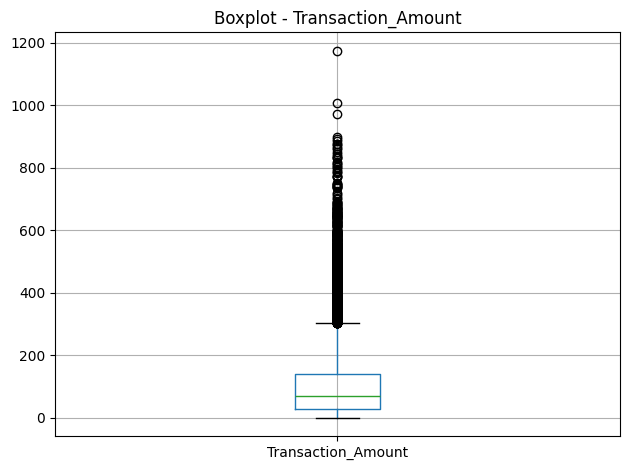

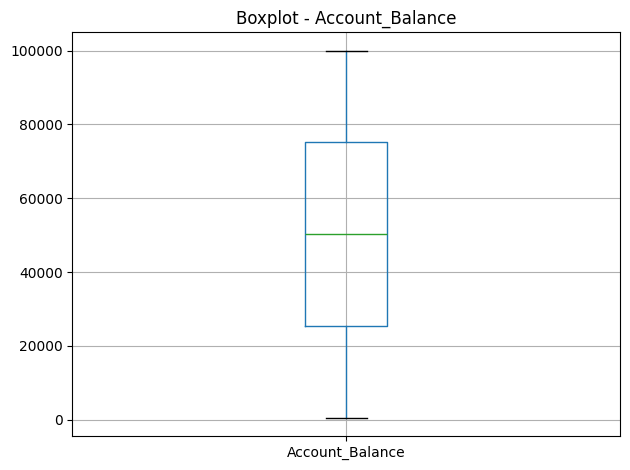

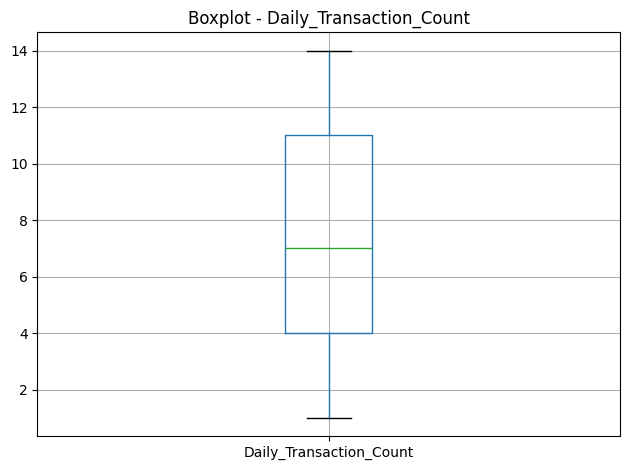

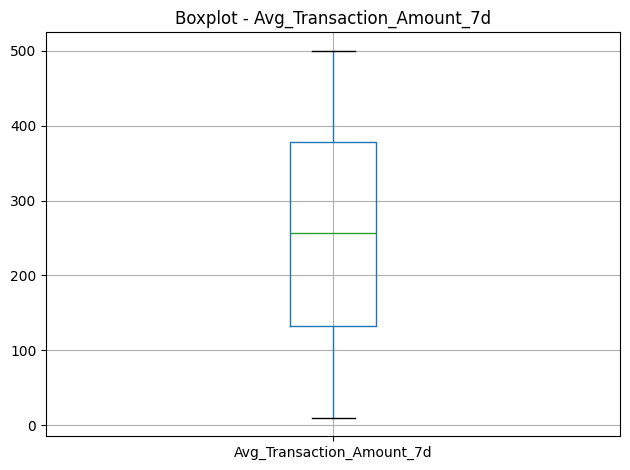

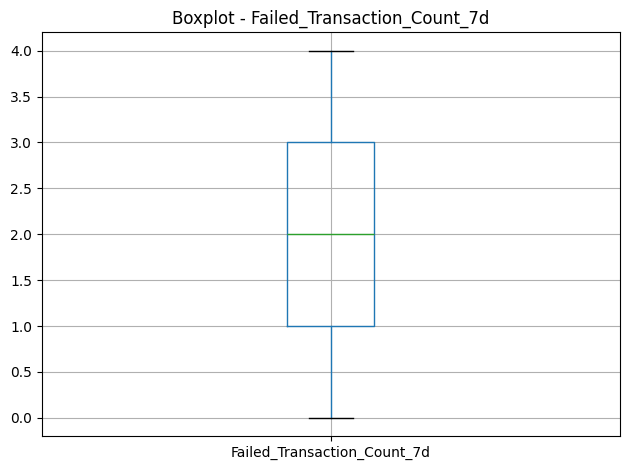

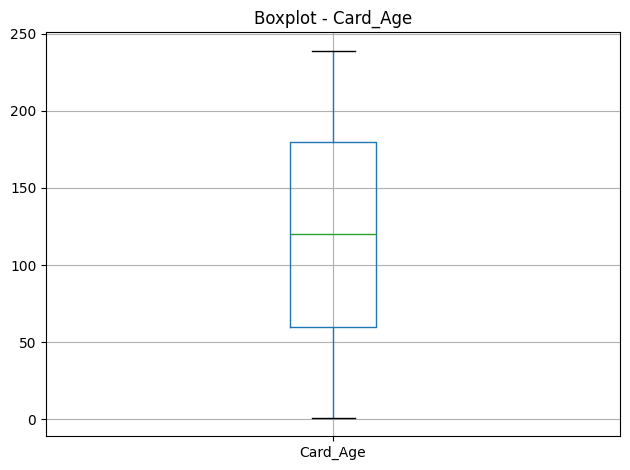

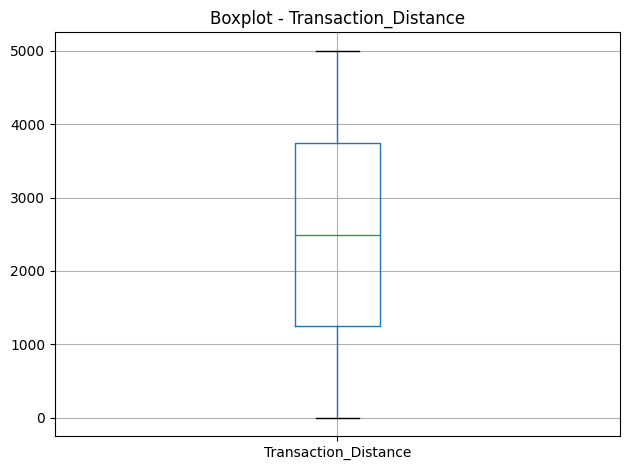

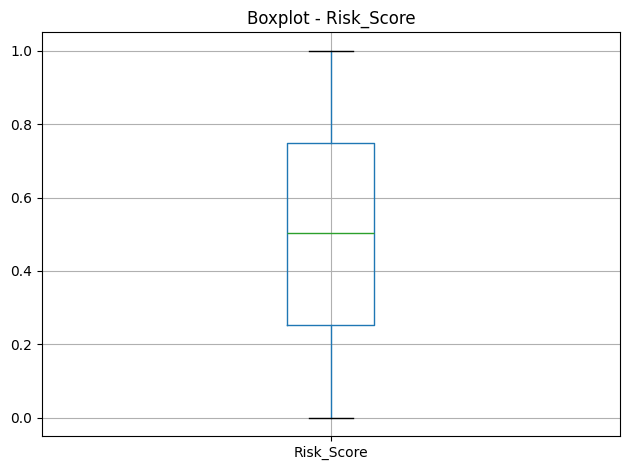

In [9]:
import matplotlib.pyplot as plt

for c in numeric_cols:
    plt.figure()
    df.boxplot(column=c)
    plt.title(f"Boxplot - {c}")
    plt.tight_layout()
    plt.show()


# Detección formal de outliers con IQR

In [10]:
# Función IQR
def iqr_bounds(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return lower, upper

# Crear flags de outliers
outlier_flags = pd.DataFrame(index=df.index)

for col in numeric_cols:
    lower, upper = iqr_bounds(df[col])
    outlier_flags[col] = ((df[col] < lower) | (df[col] > upper)).astype(int)

# Número total de outliers por fila
df["outlier_count_iqr"] = outlier_flags.sum(axis=1)

# Resumen por variable
outlier_summary = (
    outlier_flags
    .mean()
    .sort_values(ascending=False)
    .mul(100)
    .round(2)
    .to_frame("pct_outliers")
)

outlier_summary


,pct_outliers
Transaction_Amount,4.52
Account_Balance,0.00
Daily_Transaction_Count,0.00
Avg_Transaction_Amount_7d,0.00
Failed_Transaction_Count_7d,0.00
Card_Age,0.00
Transaction_Distance,0.00
Risk_Score,0.00


# Transacciones con montos “anómalos” vs su histórico (contextual)

In [11]:
# Evitar división por cero
df["amount_vs_avg_7d"] = df["Transaction_Amount"] / df["Avg_Transaction_Amount_7d"]

# Descripción rápida del ratio
df["amount_vs_avg_7d"].describe(percentiles=[0.9, 0.95, 0.99])


count    50000.000000
mean         0.798661
std          1.864890
min          0.000000
90%          1.716930
95%          3.031400
99%          8.653413
max         61.047116
Name: amount_vs_avg_7d, dtype: float64

# Marcar anomalías contextuales (por usuario)

In [ ]:
# Umbrales basados en percentiles observados
df["flag_amt_vs_avg_p95"] = (df["amount_vs_avg_7d"] > 3).astype(int)
df["flag_amt_vs_avg_p99"] = (df["amount_vs_avg_7d"] > 8).astype(int)

# Conteo rápido
df[["flag_amt_vs_avg_p95", "flag_amt_vs_avg_p99"]].mean().mul(100).round(2)


flag_amt_vs_avg_p95    5.07
flag_amt_vs_avg_p99    1.15
dtype: float64

# Relación con Fraud_Label

In [ ]:
# Tasa de fraude cuando la proporción es extrema
fraud_by_flag = (
    df
    .groupby("flag_amt_vs_avg_p99")["Fraud_Label"]
    .mean()
    .mul(100)
    .round(2)
)

fraud_by_flag


flag_amt_vs_avg_p99
0    32.10
1    35.24
Name: Fraud_Label, dtype: float64

Los resultados muestran que las transacciones con proporciones extremadamente altas presentan una mayor tasa de fraude en comparación con el resto de observaciones, lo que valida el uso del ratio como una señal relevante, aunque insuficiente de forma aislada para una detección robusta.

# Construir señales adicionales de anomalía

## Flags por distancia, riesgo y hora

In [ ]:
# Umbrales razonables por percentiles altos
dist_p99 = df["Transaction_Distance"].quantile(0.99)
risk_p90 = df["Risk_Score"].quantile(0.90)

df["flag_far_distance"] = (df["Transaction_Distance"] > dist_p99).astype(int)
df["flag_high_risk"] = (df["Risk_Score"] > risk_p90).astype(int)
df["flag_night_tx"] = ((df["hour"] >= 0) & (df["hour"] <= 5)).astype(int)

# Ver frecuencia de cada flag
df[
    ["flag_far_distance", "flag_high_risk", "flag_night_tx"]
].mean().mul(100).round(2)


flag_far_distance     1.00
flag_high_risk       10.00
flag_night_tx        24.88
dtype: float64

Se definieron umbrales basados en percentiles altos y reglas de contexto temporal con el fin de identificar comportamientos anómalos desde diferentes dimensiones del fenómeno de fraude, priorizando señales interpretables y complementarias.

# Construir un Fraud Score explicable

## Crear el score

In [16]:
# Score simple (suma de flags)
df["fraud_score_simple"] = (
    df["flag_amt_vs_avg_p99"]
    + df["flag_far_distance"]
    + df["flag_high_risk"]
    + df["flag_night_tx"]
)

# Distribución del score
df["fraud_score_simple"].value_counts().sort_index()


fraud_score_simple
0    33021
1    15476
2     1472
3       31
Name: count, dtype: int64

## Tasa de fraude por score

In [17]:
fraud_rate_by_score = (
    df
    .groupby("fraud_score_simple")["Fraud_Label"]
    .mean()
    .mul(100)
    .round(2)
)

fraud_rate_by_score


fraud_score_simple
0     24.71
1     42.47
2     88.65
3    100.00
Name: Fraud_Label, dtype: float64

Los resultados evidencian una relación creciente entre el score de riesgo construido y la tasa de fraude observada, lo que valida la utilidad del enfoque basado en reglas como mecanismo explicable de detección y priorización de transacciones sospechosas.

In [19]:
# Guardar el dataset enriquecido
df.to_csv("../data/processed/fraud_eda_enriched.csv", index=False)

# MODELOS DE FRAUDE (BASELINE + ANOMALÍAS)

## Selección de features y split

In [20]:
from sklearn.model_selection import train_test_split

# Features para ML
features = [
    # Numéricas base
    "Transaction_Amount",
    "Account_Balance",
    "Daily_Transaction_Count",
    "Avg_Transaction_Amount_7d",
    "Failed_Transaction_Count_7d",
    "Card_Age",
    "Transaction_Distance",
    "Risk_Score",

    # Señales creadas
    "flag_amt_vs_avg_p99",
    "flag_far_distance",
    "flag_high_risk",
    "flag_night_tx",

    # Score agregado
    "fraud_score_simple"
]

X = df[features]
y = df["Fraud_Label"]

# Train / test split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((35000, 13), (15000, 13))

# Baseline: Regresión Logística

## Entrenar el modelo

In [21]:
from sklearn.linear_model import LogisticRegression

# Modelo base
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  # importante para fraude
    random_state=42
)

log_reg.fit(X_train, y_train)


c:\Users\sebas\miniconda3\envs\outliers-env\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

## Predicciones y métricas

In [22]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)

# Predicciones
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

# Métricas
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, digits=4))

print("\nConfusion Matrix:")
confusion_matrix(y_test, y_pred)


ROC AUC: 0.9305

Classification report:

              precision    recall  f1-score   support

           0     0.9370    0.8225    0.8760     10180
           1     0.7020    0.8832    0.7822      4820

    accuracy                         0.8420     15000
   macro avg     0.8195    0.8528    0.8291     15000
weighted avg     0.8615    0.8420    0.8459     15000


Confusion Matrix:


array([[8373, 1807],
       [ 563, 4257]])

# Pipeline con escalado

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

log_reg_scaled = Pipeline([
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression(
        max_iter=3000,
        class_weight="balanced",
        random_state=42
    ))
])

log_reg_scaled.fit(X_train, y_train)

y_pred = log_reg_scaled.predict(X_test)
y_proba = log_reg_scaled.predict_proba(X_test)[:, 1]

print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, digits=4))
print("\nConfusion Matrix:")
confusion_matrix(y_test, y_pred)


ROC AUC: 0.9477

Classification report:

              precision    recall  f1-score   support

           0     0.9499    0.8720    0.9093     10180
           1     0.7696    0.9029    0.8309      4820

    accuracy                         0.8819     15000
   macro avg     0.8598    0.8875    0.8701     15000
weighted avg     0.8920    0.8819    0.8841     15000


Confusion Matrix:


array([[8877, 1303],
       [ 468, 4352]])

La incorporación de estandarización y balanceo de clases en el pipeline de regresión logística permitió mejorar significativamente la capacidad discriminante del modelo, incrementando tanto el recall como la precisión de la clase fraude, y reduciendo el número de fraudes no detectados.

# Isolation Forest

## Entrenar Isolation Forest

In [24]:
from sklearn.ensemble import IsolationForest

iso_features = features  # mismas features, sin label

iso_forest = IsolationForest(
    n_estimators=300,
    contamination=0.1,  # 10% anomalías esperadas
    random_state=42
)

iso_forest.fit(X_train)

# Predicciones en test
iso_pred = iso_forest.predict(X_test)

# Convertir a 0/1 (1 = anomalía)
iso_anomaly = (iso_pred == -1).astype(int)

# Vista rápida
pd.Series(iso_anomaly).value_counts(normalize=True).mul(100).round(2)


0    90.17
1     9.83
Name: proportion, dtype: float64

Se aplicó el algoritmo Isolation Forest como enfoque no supervisado para la detección de anomalías multivariadas, permitiendo identificar aproximadamente un 10% de observaciones con comportamientos atípicos sin utilizar información previa de fraude.

# Relación entre anomalías y fraude

In [25]:
# Tasa de fraude entre anomalías vs no anomalías
fraud_by_iso = (
    pd.DataFrame({
        "iso_anomaly": iso_anomaly,
        "Fraud_Label": y_test.values
    })
    .groupby("iso_anomaly")["Fraud_Label"]
    .mean()
    .mul(100)
    .round(2)
)

fraud_by_iso


iso_anomaly
0    26.94
1    79.80
Name: Fraud_Label, dtype: float64

# ANÁLISIS POR USUARIO (COMPORTAMIENTO)

## Métricas por usuario

In [26]:
user_stats = (
    df
    .groupby("User_ID")
    .agg(
        total_tx=("Transaction_ID", "count"),
        fraud_rate=("Fraud_Label", "mean"),
        avg_amount=("Transaction_Amount", "mean"),
        max_amount=("Transaction_Amount", "max"),
        avg_distance=("Transaction_Distance", "mean"),
        max_score=("fraud_score_simple", "max"),
        high_score_tx=("fraud_score_simple", lambda x: (x >= 2).sum())
    )
    .reset_index()
)

user_stats.head()


,User_ID,total_tx,fraud_rate,avg_amount,max_amount,avg_distance,max_score,high_score_tx
0,USER_1000,5,0.400000,149.736000,383.60,2812.342000,1,0
1,USER_1001,7,0.285714,124.855714,261.06,1554.188571,1,0
2,USER_1002,5,0.400000,98.146000,138.51,2767.548000,1,0
3,USER_1003,8,0.625000,79.705000,192.94,1600.077500,1,0
4,USER_1004,6,0.500000,77.755000,140.32,2819.328333,1,0


## Usuarios extremos

### Ranking de usuarios sospechosos

In [27]:
# Usuarios con mayor tasa de fraude (mínimo 5 transacciones)
top_fraud_rate = (
    user_stats[user_stats["total_tx"] >= 5]
    .sort_values("fraud_rate", ascending=False)
    .head(10)
)

top_fraud_rate


,User_ID,total_tx,fraud_rate,avg_amount,max_amount,avg_distance,max_score,high_score_tx
1332,USER_2333,5,1.000000,36.842000,86.14,3334.124000,1,0
8170,USER_9204,5,1.000000,90.790000,244.34,1950.264000,1,0
6537,USER_7562,6,1.000000,117.236667,351.94,2253.198333,1,0
3762,USER_4773,5,1.000000,92.460000,202.92,2044.112000,2,1
675,USER_1676,8,0.875000,70.236250,178.52,2319.751250,1,0
653,USER_1654,7,0.857143,108.837143,355.46,2498.632857,1,0
92,USER_1092,7,0.857143,130.664286,420.31,2468.237143,1,0
6101,USER_7124,7,0.857143,79.531429,140.32,2590.185714,1,0
8911,USER_9947,7,0.857143,116.408571,306.45,2437.095714,2,1
6320,USER_7343,7,0.857143,126.910000,485.22,2571.247143,1,0


### Usuarios con fraude severo (score >= 2)

In [28]:
top_severe = (
    user_stats[user_stats["high_score_tx"] > 0]
    .sort_values(["high_score_tx", "fraud_rate"], ascending=False)
    .head(10)
)

top_severe


,User_ID,total_tx,fraud_rate,avg_amount,max_amount,avg_distance,max_score,high_score_tx
5117,USER_6133,6,0.500000,166.291667,416.79,1993.973333,2,3
7053,USER_8080,10,0.500000,94.285000,276.46,2494.324000,2,3
5281,USER_6297,4,1.000000,95.927500,136.58,2130.882500,2,2
5585,USER_6603,3,1.000000,160.150000,230.20,3466.186667,3,2
8727,USER_9763,3,1.000000,26.073333,32.55,3188.943333,2,2
1791,USER_2793,6,0.833333,201.765000,394.60,2209.411667,2,2
1426,USER_2427,5,0.800000,88.462000,158.06,2745.162000,3,2
2074,USER_3077,5,0.800000,118.522000,268.26,2251.790000,2,2
3161,USER_4169,5,0.800000,148.564000,371.69,2907.718000,2,2
4237,USER_5251,4,0.750000,91.217500,201.29,2857.930000,2,2


## Análisis temporal por usuario

### Ordenar transacciones por usuario y tiempo

In [29]:
# Asegurar orden temporal
df_sorted = df.sort_values(["User_ID", "Timestamp"]).copy()

# Diferencia de tiempo entre transacciones del mismo usuario (en minutos)
df_sorted["minutes_since_prev_tx"] = (
    df_sorted
    .groupby("User_ID")["Timestamp"]
    .diff()
    .dt.total_seconds()
    .div(60)
)

df_sorted[["User_ID", "Timestamp", "minutes_since_prev_tx", "Fraud_Label"]].head(10)


,User_ID,Timestamp,minutes_since_prev_tx,Fraud_Label
47834,USER_1000,2023-02-21 10:25:00,NaN,1
28102,USER_1000,2023-04-26 23:17:00,92932.0,0
13089,USER_1000,2023-09-01 20:09:00,184132.0,1
21475,USER_1000,2023-10-29 03:47:00,82538.0,0
41209,USER_1000,2023-12-03 06:43:00,50576.0,0
37197,USER_1001,2023-01-25 12:16:00,NaN,1
3764,USER_1001,2023-02-20 18:12:00,37796.0,0
23993,USER_1001,2023-03-18 06:17:00,36725.0,0
42185,USER_1001,2023-09-16 07:14:00,262137.0,1
26153,USER_1001,2023-09-17 07:35:00,1461.0,0


### Identificar ráfagas sospechosas

In [30]:
# Flag de ráfaga
df_sorted["burst_tx"] = (df_sorted["minutes_since_prev_tx"] <= 10).astype(int)

# Frecuencia de ráfagas
df_sorted["burst_tx"].mean().round(3)


np.float64(0.0)

### ¿Las ráfagas son más fraudulentas?

In [31]:
# Fraude en ráfagas vs no ráfagas
fraud_by_burst = (
    df_sorted
    .groupby("burst_tx")["Fraud_Label"]
    .mean()
    .mul(100)
    .round(2)
)

fraud_by_burst


burst_tx
0    32.14
1    20.00
Name: Fraud_Label, dtype: float64

El análisis de ráfagas temporales mostró que, bajo el umbral considerado, las transacciones cercanas en el tiempo no presentan una mayor tasa de fraude, lo que sugiere que este patrón no constituye una señal relevante en el contexto del conjunto de datos analizado.